<a href="https://colab.research.google.com/github/FedericaChiti/Null_Finder/blob/main/Federica_Chiti_Cats_Dogs_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Retrieving files from the drive

In [2]:
# download data directly from Google Drive 
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/cat_dog_small.zip", 'r')
zip_ref.extractall()

Mounted at /content/drive/


In [3]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/cat_dog_full.zip", 'r')
zip_ref.extractall()

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Importing useful modules

In [14]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Defining model architecture

In [10]:
# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        #call constructor of class nn.Module and initialize the inherited properties and methods of the CNN class.
        super(CNN, self).__init__()
        #define first convolutional 2d layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        #batch normalization 
        self.bn1 = nn.BatchNorm2d(32)
        #define second convolutional 2d layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        #batch normalization 
        self.bn2 = nn.BatchNorm2d(64)
        #define third convolutional 2d layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        #batch normalization 
        self.bn3 = nn.BatchNorm2d(128)
        #define max pooling layer that downsamples the spatial dimensions of the input by a factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #define fully connected layers
        self.fc1 = nn.Linear(in_features=128 * 16 * 16, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        #define dropout layer that randomly sets 50% of the activations to zero during training.
        # self.dropout = nn.Dropout(p=0.5) #this makes the loss oscillating between 0.6 and 0.7
        #maybe it's too high... should try lower this to see if it converges
        #define activation function that applies the rectified linear unit (ReLU) function element-wise to the input.
        self.relu = nn.ReLU()

    def forward(self, x):
      #define forward pass of a 3-layer CNN model
        #first convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        #second convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        #third convolutional layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        #the output tensor is flattened using the view method to a 1D tensor
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x


# Defining data augmentation and loading the data

In [23]:
# Define the data preprocessing
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the data from the full dataset 
train_dataset_full = datasets.ImageFolder(root='./dataset/training_set/', transform=transform)
train_loader_full = DataLoader(train_dataset_full, batch_size=64, shuffle=True)
test_dataset_full = datasets.ImageFolder(root='./dataset/test_set/', transform=transform)
test_loader_full = DataLoader(test_dataset_full, batch_size=64, shuffle=False)


# Load the data from the smaller dataset
train_dataset = torchvision.datasets.ImageFolder(root='./cat_dog/train/', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.ImageFolder(root='./cat_dog/test/', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)



# Training and testing the model using the smaller dataset

In [24]:
# Define the loss function and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Epoch [1/10], Step [1/50], Loss: 0.7990
Epoch [1/10], Step [11/50], Loss: 0.8319
Epoch [1/10], Step [21/50], Loss: 0.5973
Epoch [1/10], Step [31/50], Loss: 0.5651
Epoch [1/10], Step [41/50], Loss: 0.6063
Epoch [2/10], Step [1/50], Loss: 0.5518
Epoch [2/10], Step [11/50], Loss: 0.5510
Epoch [2/10], Step [21/50], Loss: 0.5798
Epoch [2/10], Step [31/50], Loss: 0.5144
Epoch [2/10], Step [41/50], Loss: 0.5410
Epoch [3/10], Step [1/50], Loss: 0.5251
Epoch [3/10], Step [11/50], Loss: 0.3646
Epoch [3/10], Step [21/50], Loss: 0.5660
Epoch [3/10], Step [31/50], Loss: 0.5288
Epoch [3/10], Step [41/50], Loss: 0.4431
Epoch [4/10], Step [1/50], Loss: 0.5007
Epoch [4/10], Step [11/50], Loss: 0.4730
Epoch [4/10], Step [21/50], Loss: 0.3893
Epoch [4/10], Step [31/50], Loss: 0.4450
Epoch [4/10], Step [41/50], Loss: 0.4195
Epoch [5/10], Step [1/50], Loss: 0.4923
Epoch [5/10], Step [11/50], Loss: 0.3848
Epoch [5/10], Step [21/50], Loss: 0.3528
Epoch [5/10], Step [31/50], Loss: 0.3909
Epoch [5/10], Step [4

# Plotting ROC and computing AUC

In [ ]:
# Set the model to evaluation mode
model.eval()

# Get the predicted probabilities and true labels for the test set
probs = []
labels = []
with torch.no_grad():
    for images, true_labels in test_loader:
        outputs = model(images)
        batch_probs = torch.softmax(outputs, dim=1)[:, 1].numpy()
        probs.extend(batch_probs)
        labels.extend(true_labels.numpy())

# Calculate the fpr and tpr for different threshold values
fpr, tpr, thresholds = roc_curve(labels, probs)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

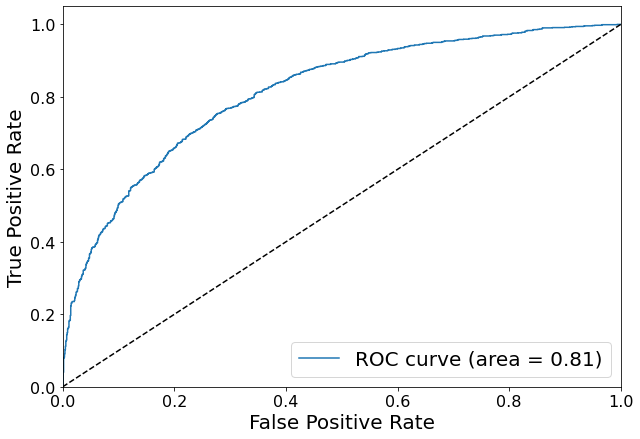

In [27]:
# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.legend(loc="lower right",fontsize=20)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.show()


This looks like a good start for this model architecture. The AUC value is closer to 1 than 0.5 and the ROC curve is leaning toward the upper left corner of the plot, which indicates that the performance of this classifier is promising. The loss is also gradually decreasing across the epochs, which is a good sign! I am only using 10 epochs and a learning rate of 0.001, so I can tune these hyperparameters when training and testing the model on the full datasets. 

# Training and testing the model using the full dataset

For the full dataset, I am going to increase the number of epochs from 10 to 25 and decreasing the learning rate from 0.001 to 0.0001

In [12]:
# Define the loss function and optimizer
model_full = CNN()
criterion_full = nn.CrossEntropyLoss()
optimizer_full = optim.Adam(model_full.parameters(), lr=0.0001)

# Train the model
num_epochs = 25
for epoch in range(num_epochs):
    for i, (images_full, labels_full) in enumerate(train_loader_full):
        # Forward pass
        outputs_full = model_full(images_full)
        loss_full = criterion_full(outputs_full, labels_full)
        # Backward and optimize
        optimizer_full.zero_grad()
        loss_full.backward()
        optimizer_full.step()
        if (i) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, len(train_loader_full), loss_full.item()))
    torch.save(model_full.state_dict(), "/content/drive/My Drive/model{}.pth".format(epoch))
    print("Saved PyTorch Model State to model{}.pth".format(epoch))

# Test the model
model_full.eval()
with torch.no_grad():
    correct_full = 0
    total_full = 0
    for images_full, labels_full in test_loader_full:
        outputs_full = model_full(images_full)
        _, predicted_full = torch.max(outputs_full.data, 1)
        total_full += labels_full.size(0)
        correct_full += (predicted_full == labels_full).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct_full / total_full))



Epoch [1/25], Step [1/125], Loss: 0.7130
Epoch [1/25], Step [101/125], Loss: 0.6030
Saved PyTorch Model State to model0.pth
Epoch [2/25], Step [1/125], Loss: 0.5300
Epoch [2/25], Step [101/125], Loss: 0.5517
Saved PyTorch Model State to model1.pth
Epoch [3/25], Step [1/125], Loss: 0.4477
Epoch [3/25], Step [101/125], Loss: 0.3751
Saved PyTorch Model State to model2.pth
Epoch [4/25], Step [1/125], Loss: 0.4081
Epoch [4/25], Step [101/125], Loss: 0.3856
Saved PyTorch Model State to model3.pth
Epoch [5/25], Step [1/125], Loss: 0.3263
Epoch [5/25], Step [101/125], Loss: 0.4460
Saved PyTorch Model State to model4.pth
Epoch [6/25], Step [1/125], Loss: 0.2831
Epoch [6/25], Step [101/125], Loss: 0.3040
Saved PyTorch Model State to model5.pth
Epoch [7/25], Step [1/125], Loss: 0.2611
Epoch [7/25], Step [101/125], Loss: 0.3760
Saved PyTorch Model State to model6.pth
Epoch [8/25], Step [1/125], Loss: 0.2165
Epoch [8/25], Step [101/125], Loss: 0.3414
Saved PyTorch Model State to model7.pth
Epoch [9

# Plotting ROC and computing AUC

In [ ]:
# Set the model to evaluation mode
model_full.eval()

# Get the predicted probabilities and true labels for the test set
probs = []
labels = []
with torch.no_grad():
    for images, true_labels in test_loader_full:
        outputs = model_full(images)
        batch_probs = torch.softmax(outputs, dim=1)[:, 1].numpy()
        probs.extend(batch_probs)
        labels.extend(true_labels.numpy())

# Calculate the fpr and tpr for different threshold values
fpr, tpr, thresholds = roc_curve(labels, probs)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

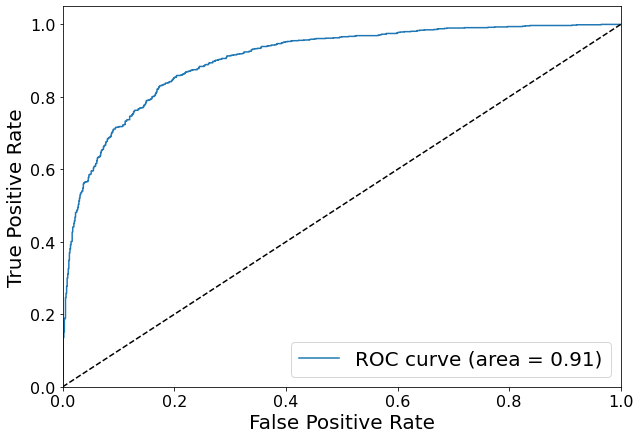

In [22]:
# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.legend(loc="lower right",fontsize=20)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

Ideally, a binary classifier would have a high TPR and a low FPR at all thresholds, which would correspond to a curve that hugs the upper-left corner of the plot. The plot above shows that the ROC curve obtained for this model is following this behavior, suggesting that this is a good binary classifier.

In general, the closer the ROC curve is to the upper-left corner of the plot, and the higher the AUC, the better the performance of the classifier. The AUC I obtain is 0.91, which indicates that the model has a good ability to distinguish between the positive and negative classes. A perfect classifier would have an AUC of 1, and a random classifier would have an AUC of 0.5. 

The accuracy of the model on the test images is 82%. An accuracy of 82% means that 82% of the test set instances were correctly classified by the model.

Furthermore, we can notice that the loss is gradually decreasing from 0.7 to 0.007 across the 25 epochs during training, meaning that the model is learning to fit the training data better and thus make better predictions over time.